## Projekt: Rekonstrukcja kinematyki rozpadu Higgs → ττ za pomocą sieci neuronowej

### **Autor:** Jakub Kuśmierski  
### **Data:** 23.04.2025  
### **Opis:**   
Celem projektu jest stworzenie modelu regresyjnego o architekturze Fully Connected Neural Network (FCNN), którego zadaniem jest rekonstrukcja parametrów kinematycznych bozonu Higgsa oraz cząstek τ na podstawie danych symulacyjnych. 

Zazwyczaj problem wynika z faktu, że w rozpadzie taonów nie obserwujemy neutrin, które wynoszą ze zdarzenia część energii i pędu. Ich odtworzenie jest trudne w środowisku maszyny hadronowej, a MET (Missing Transverse Energy), który zawiera ich wkład, jest odtwarzany z dużą niedokładnością.

Model będzie oceniany poprzez porównanie jego wyników z obecnie stosowanym narzędziem referencyjnym fastMTT.

### Diagram Feynmana dla procesu Higgs → ττ

![Diagram Feynmanna dla procesu $H -> \tau \tau $](https://www.researchgate.net/publication/303921835/figure/fig2/AS:651132598751241@1532253517741/Feynman-diagram-describing-the-decay-H-t-t-with-one-t-subsequently-decaying.png)

## Definicja danych wejściowych i wyjściowych

### Dane wejściowe (cechy modelu)

- `dm1`, `dm2` – różnica masy (delta mass) w rozpadzie τ1 i τ2  
- `pt1`, `pt2` – pęd poprzeczny pierwszego i drugiego produktu rozpadu τ  
- `eta1`, `eta2` – pseudopospółrzędna η pierwszego i drugiego produktu  
- `phi1`, `phi2` – azymut pierwszego i drugiego produktu  
- `mass1`, `mass2` – masa widzialna produktów rozpadu (może to być np. układ hadronowy)  
- `trueMETx`, `trueMETy` – wygenerowane wartości brakującej energii poprzecznej (MET), komponenty w kierunkach x i y  
- `var_xx`, `var_yy` – wariancje niepewności MET w kierunkach x i y  
- `cov_xy` – kowariancja między komponentami x i y MET

###  Dane wyjściowe (predykcje modelu)

####  Kinematyka bozonu Higgsa:
- `H_m` – masa bozonu Higgsa  
- `H_pt` – pęd poprzeczny Higgsa  
- `H_eta` – pseudopospieszność η bozonu Higgsa  
- `H_phi` – azymut φ bozonu Higgsa  

####  Kinematyka cząstki τ1:
- `tau1_m` – masa cząstki τ1  
- `tau1_pt` – pęd poprzeczny τ1  
- `tau1_eta` – pseudopospieszność τ1  
- `tau1_phi` – azymut τ1  

####  Kinematyka cząstki τ2:
- `tau2_m` – masa cząstki τ2  
- `tau2_pt` – pęd poprzeczny τ2  
- `tau2_eta` – pseudopospspieszność τ2  
- `tau2_phi` – azymut τ2


Kinematyka τ1 i τ2, jeśli uda się wykonać, w głównej mierze chce skupić pracę na początek na kinmatyce bozonu Higgsa i dopiero później nad taonami.

**Uwaga dotycząca danych MET:**  
W projekcie planowane jest dodatkowe przetwarzanie danych MET (`trueMETx`, `trueMETy`), polegające na ich rozmyciu zgodnie z rozkładem normalnym (Gaussa), w celu zasymulowania realizmu rekonstrukcji eksperymentalnej. Rozkład ten może mieć zmienną wariancję dla każdej próbki, co pozwoli zwiększyć odporność modelu na przeuczenie względem statystyki MET oraz lepiej odzwierciedli warunki rzeczywistych eksperymentów hadronowych. Takie podejście ma na celu przygotowanie sieci do bardziej uniwersalnego działania w warunkach różnych rozrzutów niepewności.



## Lokalizacja danych

Dane do projektu znajdują się na scratch_cmsse, naleącym do doktoranta Wiktora Matyszkiewicza z Wydaiłu Fizyki Uniwersytetu Warszawskiego.

```Python
    data_path = "/home/wmatyszk/scratch_cmsse/wmatyszk/project_sieci/csv/"
```

## Przewidywana architektura modelu

Model zastosowany w projekcie będzie oparty na architekturze **Fully Connected Neural Network (FCNN)**. Jego zadaniem będzie predykcja ciągłych parametrów kinematycznych bozonu Higgsa oraz cząstek τ, bazując na danych symulacyjnych z rekonstrukcją MET i obserwowanych produktach rozpadu.

#### **Etap bazowy – klasyczny FCNN**
Na pierwszym etapie projekt zakłada zastosowanie pojedynczej, w pełni połączonej sieci neuronowej o następującej strukturze:
- **Wejście:** wektor złożony z obserwowalnych parametrów rozpadu (pędy poprzeczne, kąty, masy, MET oraz jego wariancje i kowariancja)
- **Część ukryta:** kilka warstw Dense z funkcją aktywacji ReLU i regularizacją (np. Dropout), których liczba i szerokość zostaną ustalone eksperymentalnie
- **Wyjście:** 12-wymiarowy wektor z wartościami kinematycznymi Higgsa i obu taonów (masa, pT, eta, phi dla każdej z trzech cząstek)

Model ten będzie uczył się funkcji odwzorowującej dane wejściowe na pełną rekonstrukcję rozpadu Higgs → τ⁺τ⁻, przy czym trening będzie nadzorowany i oparty na rzeczywistych wartościach wygenerowanych w symulacji.

#### **Etap rozszerzony – architektura dwugałęziowa**
Na późniejszym etapie rozważone zostanie wdrożenie **dwugałęziowej architektury FCNN**, w której:
- **Gałąź pierwsza** przetwarza informacje dotyczące **rozpadu taonów** (parametry masy, pędu, kąta i masy produktów)
- **Gałąź druga** przetwarza parametry związane z **MET** (trueMETx, trueMETy, wariancje, kowariancja)
- Po przetworzeniu każdej z gałęzi, ich reprezentacje będą **łączone (concatenate)** i dalej przetwarzane w wspólnej części modelu w celu dokonania końcowej predykcji

Celem takiego rozwiązania jest umożliwienie modelowi osobnej specjalizacji w dwóch fizycznie różnych typach informacji – jednej związanej z widzialnymi cząstkami, drugiej z efektem nieobserwowalnych neutrin.

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np
import pandas as pd
import ast
import glob
import functools

#The tensorflow library
import tensorflow  as tf
import tensorflow_datasets as tfds

#Plotting libraries
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

import importlib
import sys
sys.path.append("/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

import project as project
importlib.reload(project);

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
data_dir = '/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/data/sieci/'
csv_files = glob.glob(data_dir + "Higgs*.csv")

In [3]:
dfs = []

for file in csv_files:
    df = pd.read_csv(file)

    for col in ['tau.pt', 'tau.eta', 'tau.phi', 'H.pt', 'H.eta', 'H.phi']:
        df[col] = df[col].apply(ast.literal_eval)

    
    df['tau1_pt'] = df['tau.pt'].apply(lambda x: x[0])
    df['tau2_pt'] = df['tau.pt'].apply(lambda x: x[1])
    df['tau1_eta'] = df['tau.eta'].apply(lambda x: x[0])
    df['tau2_eta'] = df['tau.eta'].apply(lambda x: x[1])
    df['tau1_phi'] = df['tau.phi'].apply(lambda x: x[0])
    df['tau2_phi'] = df['tau.phi'].apply(lambda x: x[1])
    df['H_pt'] = df['H.pt'].apply(lambda x: x[0])
    df['H_eta'] = df['H.eta'].apply(lambda x: x[0])
    df['H_phi'] = df['H.phi'].apply(lambda x: x[0])

    df.drop(columns=['tau.pt', 'tau.eta', 'tau.phi', 'H.pt', 'H.eta', 'H.phi'], inplace=True)

    dfs.append(df)

In [4]:
df = pd.concat(dfs, ignore_index=True)
df.head()

,H.m,H.E,t1.m,t1.E,t2.m,t2.E,METx,METy,trueMETx,trueMETy,...,type2,tau1_pt,tau2_pt,tau1_eta,tau2_eta,tau1_phi,tau2_phi,H_pt,H_eta,H_phi
0,196.73200,282.94920,1.77682,184.299360,1.77682,98.64985,-50.879560,-7.675525,-52.073196,-13.297127,...,-1,76.953780,98.63361,1.519704,-0.002149,-2.765061,1.797632,115.700005,1.164141,2.515362
1,170.96394,454.64020,1.77682,127.403140,1.77682,327.23706,236.432200,-97.585000,246.659970,-110.700200,...,-1,124.511536,228.12059,0.214641,0.901347,-0.984634,-0.233547,330.250270,0.726369,-0.493766
2,403.04907,770.57380,1.77682,453.754670,1.77682,316.81910,18.701082,-1.000554,14.325636,21.218117,...,-1,90.911680,252.49693,-2.290618,-0.699414,-2.556309,0.778071,164.195970,-2.063401,0.884353
3,218.99274,233.65942,1.77682,108.677956,1.77682,124.98147,-43.222538,-18.162619,-33.788174,-6.049116,...,-1,102.301540,117.20386,-0.350866,-0.362030,0.301128,-2.878016,15.459115,-2.346176,-3.129083
4,234.15674,251.93723,1.77682,99.779755,1.77682,152.15747,104.295290,-8.689900,90.916330,-2.842107,...,-1,76.937290,137.41629,0.752438,-0.458990,2.402238,-0.038647,92.950200,-0.019375,0.524304


In [5]:
print(colored("Columns in the dataset:\n", 'green'), df.columns.values)
print(colored("Shape of the dataset:\n", 'red'), df.shape)

Columns in the dataset:
 ['H.m' 'H.E' 't1.m' 't1.E' 't2.m' 't2.E' 'METx' 'METy' 'trueMETx'
 'trueMETy' 'dm1' 'pt1' 'eta1' 'phi1' 'mass1' 'type1' 'dm2' 'pt2' 'eta2'
 'phi2' 'mass2' 'type2' 'tau1_pt' 'tau2_pt' 'tau1_eta' 'tau2_eta'
 'tau1_phi' 'tau2_phi' 'H_pt' 'H_eta' 'H_phi']
Shape of the dataset:
 (35586, 31)


In [6]:
input_features = [
    'dm1', 'pt1', 'eta1', 'phi1', 'mass1',
    'dm2', 'pt2', 'eta2', 'phi2', 'mass2',
    'trueMETx', 'trueMETy'
]

output_targets = [
    'H.m', 'H_pt', 'H_eta', 'H_phi',
    't1.m', 'tau1_pt', 'tau1_eta', 'tau1_phi',
    't2.m', 'tau2_pt', 'tau2_eta', 'tau2_phi'
]


output_targets = ['H.m', 'H_pt','tau1_pt','tau2_pt']


#output_targets = ['H.m', 'H_pt']

In [7]:
features = df[input_features].astype('float32').values
labels = df[output_targets].astype('float32').values

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))

print(colored("Dataset:\n", 'blue'), dataset)
print(colored("Dataset length:\n", 'green'), len(features))

Dataset:
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(12,), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>
Dataset length:
 35586


In [9]:
nStepsPerEpoch = project.nStepsPerEpoch
batchSize = project.batchSize
output_shape = len(output_targets)
buffor_size = project.buffor_size

minval = 5.0
maxval = 55.0
mean = 0.0
stddev = 1.0
rho_min = -1.0
rho_max = 1.0

adding_smeard_MET = functools.partial(project.add_smeared_MET, minval=minval, maxval=maxval, mean=mean, stddev=stddev, rho_min=rho_min, rho_max=rho_max)

dataset_train_preaper = dataset.batch(batchSize).map(adding_smeard_MET).take(nStepsPerEpoch).cache()

item = next(iter(dataset_train_preaper))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (32, 17)
Labels shape: (32, 4)


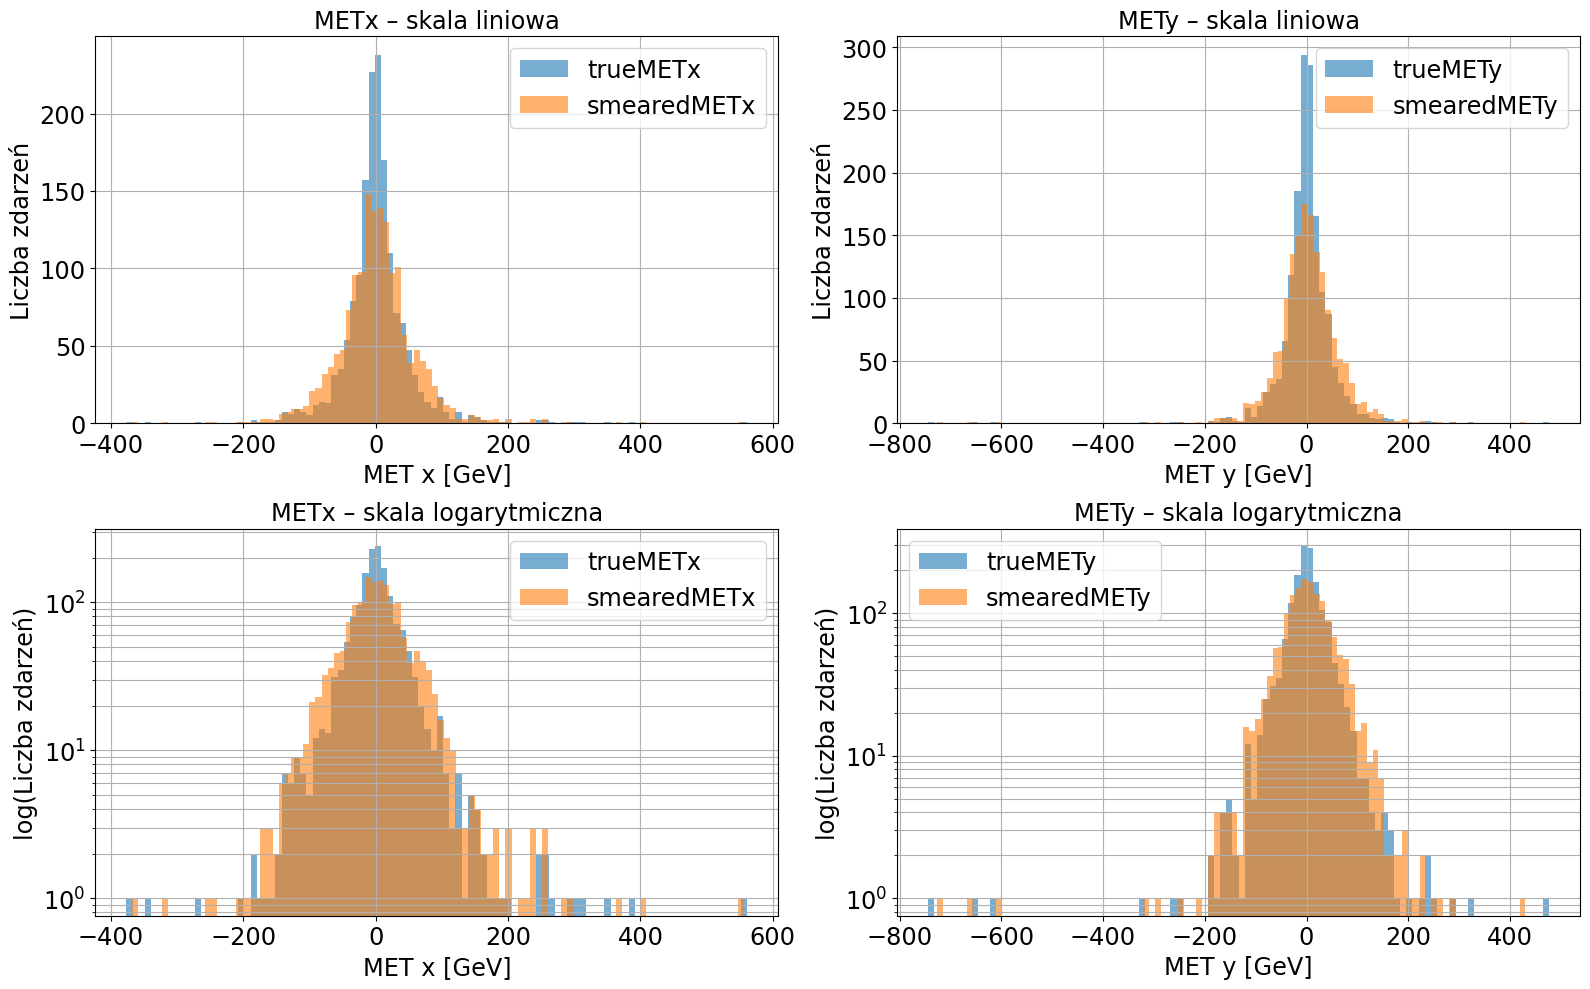

In [10]:
project.plot_MET(dataset_train_preaper)

In [11]:
dataset_train = dataset_train_preaper.map(project.remove_true_MET).cache()

item = next(iter(dataset_train))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (32, 15)
Labels shape: (32, 4)


In [12]:
tfds.benchmark(dataset_train)

/opt/anaconda3/envs/tf311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



************ Summary ************



100%|██████████| 1112/1112 [00:00<00:00, 13482.38it/s]

Examples/sec (First included) 10042.01 ex/sec (total: 1113 ex, 0.11 sec)
Examples/sec (First only) 33.75 ex/sec (total: 1 ex, 0.03 sec)
Examples/sec (First excluded) 13693.35 ex/sec (total: 1112 ex, 0.08 sec)


,duration,num_examples,avg
first+lasts,0.110834,1113,10042.014689
first,0.029627,1,33.752949
lasts,0.081207,1112,13693.351577


## Model FCNN

In [13]:
model_fc = tf.keras.Sequential(layers=[
    tf.keras.Input(shape=(15,), name="model_input"),
    
    tf.keras.layers.Normalization(),
    
    tf.keras.layers.Dense(64, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),

    tf.keras.layers.Dense(128, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),

    tf.keras.layers.Dense(256, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),
    
    tf.keras.layers.Dense(512, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),
    
    tf.keras.layers.Dense(128, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),
    
    tf.keras.layers.Dense(64, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),
    
    tf.keras.layers.Dense(32, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),

    tf.keras.layers.Dense(output_shape, activation='relu', name="output") 
], name="FC_regression_model")

model_fc.summary()

Model: "FC_regression_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 15)             │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,115 (977.02 KB)

 Trainable params: 250,084 (976.89 KB)

 Non-trainable params: 31 (128.00 B)

Epoch 1/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8905 - loss: 304.6622 - val_accuracy: 0.9243 - val_loss: 222.4491
Epoch 2/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9160 - loss: 224.5826 - val_accuracy: 0.9243 - val_loss: 215.8720
Epoch 3/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9159 - loss: 218.2342 - val_accuracy: 0.9238 - val_loss: 212.4110
Epoch 4/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9157 - loss: 214.7267 - val_accuracy: 0.9241 - val_loss: 211.0017
Epoch 5/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9147 - loss: 211.5711 - val_accuracy: 0.9229 - val_loss: 172.6661
Epoch 6/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9149 - loss: 172.9118 - val_accuracy: 0.9253 - val_loss: 169.5692
Epoch 7/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9134 - loss: 168.4497 - val_accuracy: 0.9263 - val_loss: 167.9607
Epoch 8/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.91

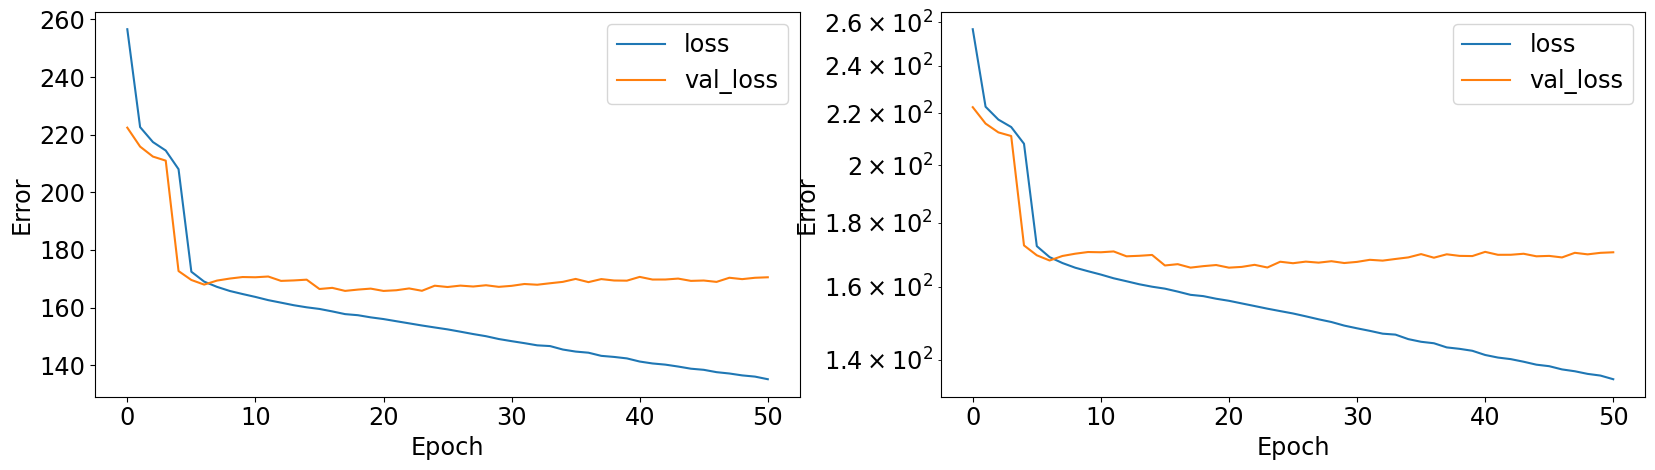

In [14]:
total_dataset = dataset_train.shuffle(buffor_size).cache()
val_batches = total_dataset.take(128)
train_batches = total_dataset.skip(128)

importlib.reload(project);

model_fc = project.trainModel(model_fc, train_data=train_batches, val_data=val_batches, nEpochs=300)

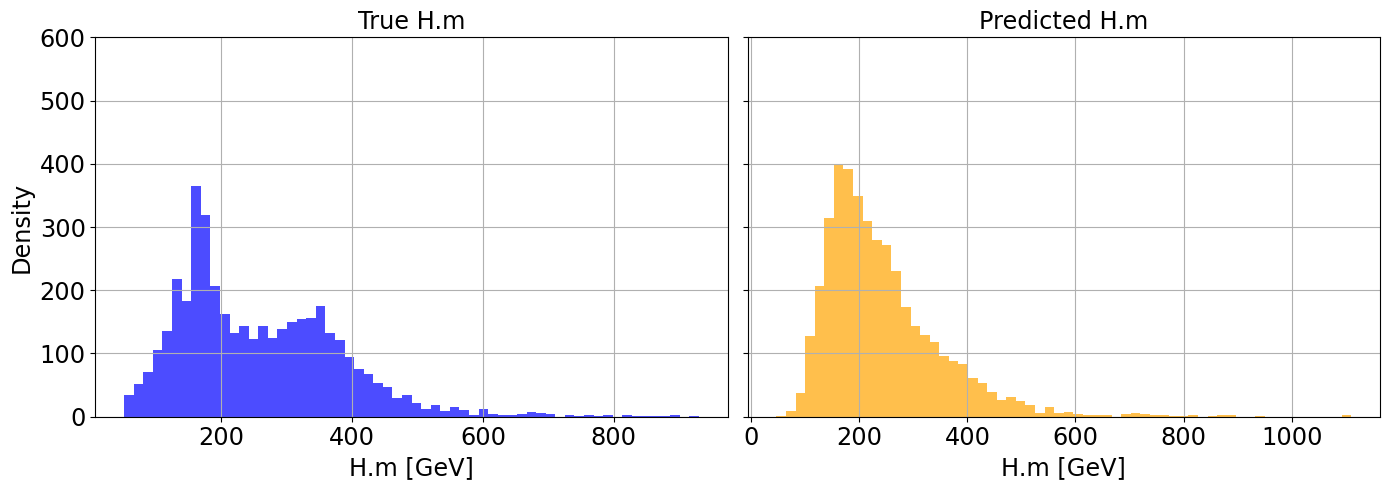

In [15]:
project.plot_H_mass(model_fc, val_batches)

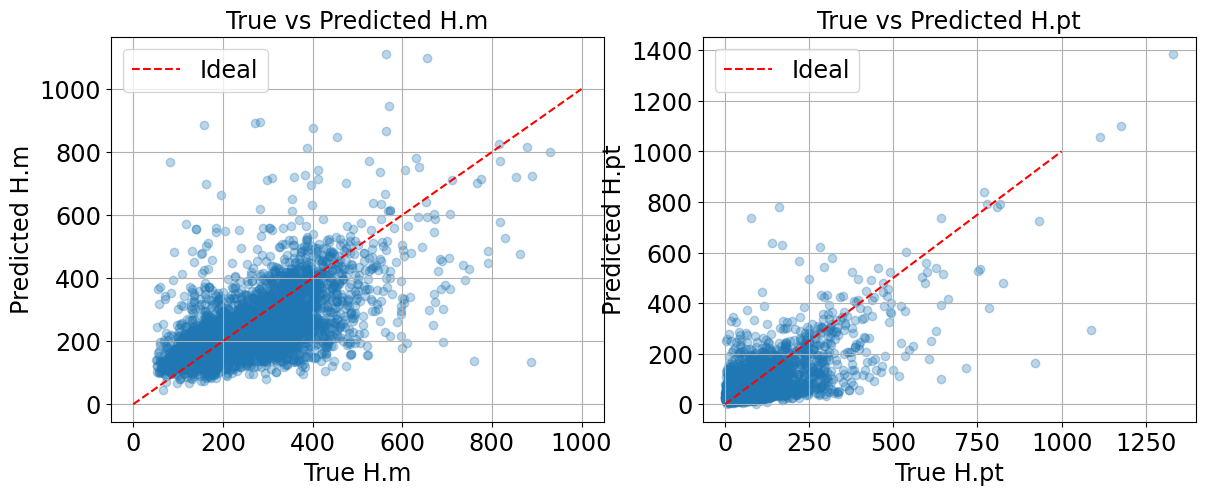

In [16]:
project.true_vs_predict_H_mass(model_fc, val_batches)

True Higgs mass:  175.37257  and predicted: 242.10869


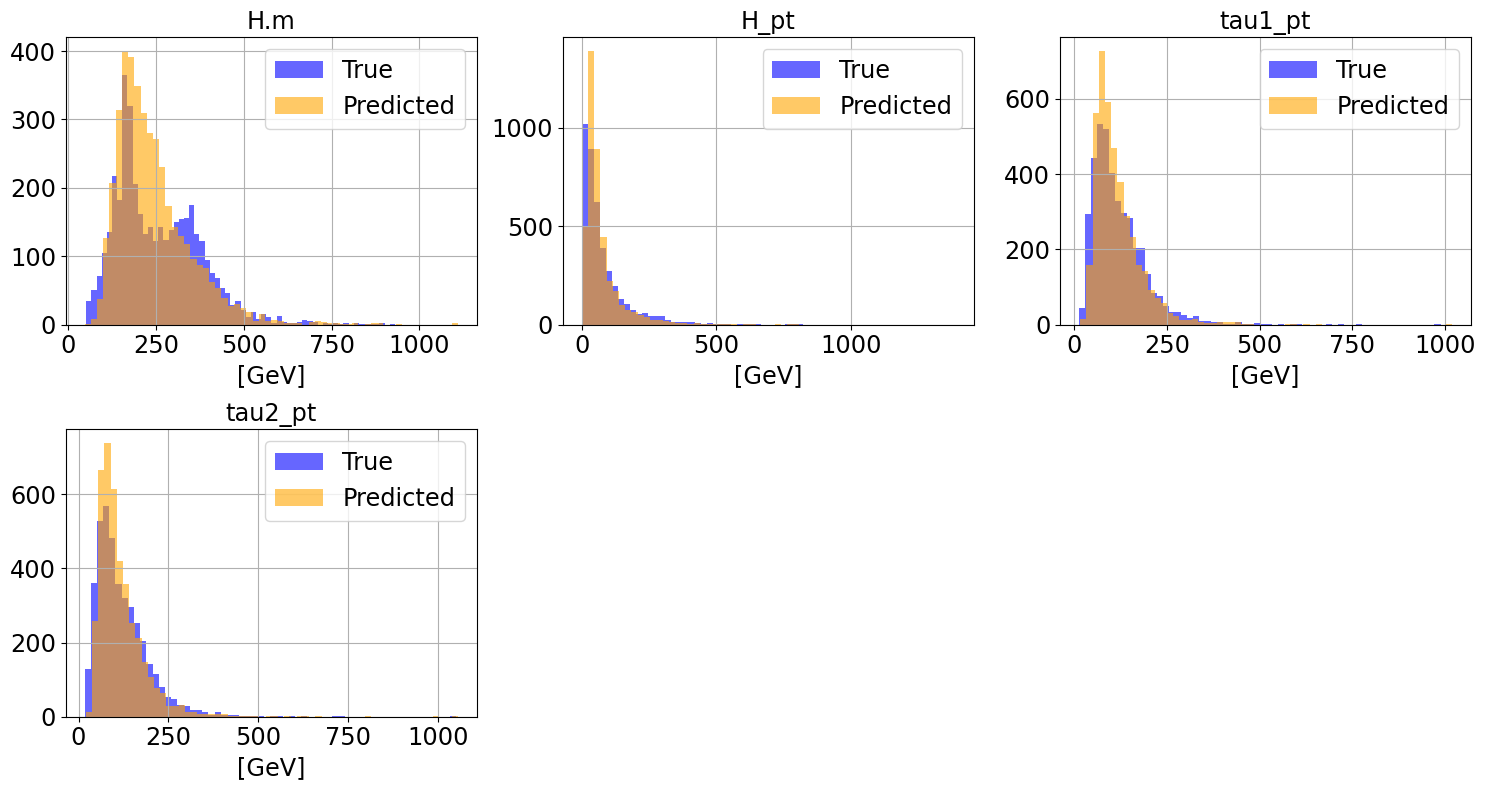

In [17]:
project.plot_all_labels(model_fc, val_batches, output_targets)

[H.m] sigma = 101.2580
[H_pt] sigma = 72.2897
[tau1_pt] sigma = 47.2009
[tau2_pt] sigma = 47.3311


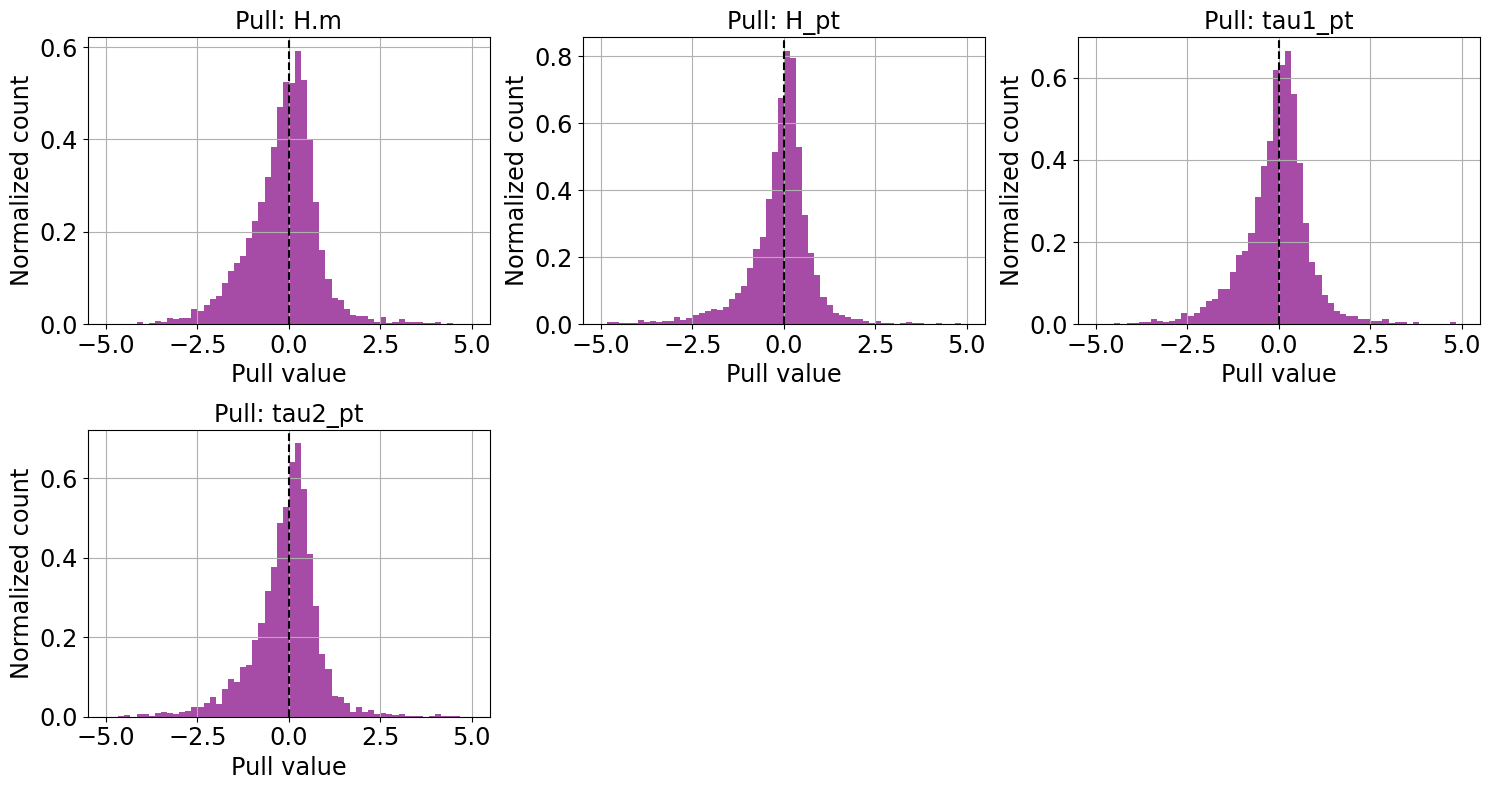

In [18]:
project.plot_all_pulls(model_fc, val_batches, output_targets)

## Model architektury dwugałęziowej

In [19]:
dataset_train_test = dataset_train.unbatch()
dataset_split = dataset_train_test.map(project.split_inputs).batch(batchSize).cache()

total_dataset = dataset_split.shuffle(buffor_size).cache()
val_batches = total_dataset.take(128)
train_batches = total_dataset.skip(128)

In [20]:
input_particles = tf.keras.Input(shape=(10,), name="particles_input")
input_met = tf.keras.Input(shape=(5,), name="met_input")

# Gałąź cząstek
norm_particles = tf.keras.layers.Normalization()(input_particles)
x1 = tf.keras.layers.Dense(64, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(norm_particles)
x1 = tf.keras.layers.Dense(128, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x1)
x1 = tf.keras.layers.Dense(256, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x1)

# Gałąź MET
norm_met = tf.keras.layers.Normalization()(input_met)
x2 = tf.keras.layers.Dense(32, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(norm_met)
x2 = tf.keras.layers.Dense(64, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x2)
x2 = tf.keras.layers.Dense(128, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x2)

# Połączenie
x = tf.keras.layers.concatenate([x1, x2])
x = tf.keras.layers.Dense(512, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(256, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(128, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(64, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
output = tf.keras.layers.Dense(output_shape, activation='linear', name='output')(x)

model_dual = tf.keras.Model(inputs={'particles_input': input_particles, 'met_input': input_met}, outputs=output)

model_dual.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ particles_input     │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input           │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 10)        │         21 │ particles_input[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 5)         │         11 │ met_input[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │        704 │ normalization_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │        192 │ normalization_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      8,320 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      2,112 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     33,024 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │      8,320 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │    197,120 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      8,256 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4)         │        260 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 422,564 (1.61 MB)

 Trainable params: 422,532 (1.61 MB)

 Non-trainable params: 32 (136.00 B)

Epoch 1/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8770 - loss: 264.7720 - val_accuracy: 0.9241 - val_loss: 220.7172
Epoch 2/300
  1/984 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 1.0000 - loss: 342.1279

/opt/anaconda3/envs/tf311/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9189 - loss: 177.8440 - val_accuracy: 0.9238 - val_loss: 197.3472
Epoch 3/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9193 - loss: 169.8917 - val_accuracy: 0.9263 - val_loss: 192.4544
Epoch 4/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9198 - loss: 167.3079 - val_accuracy: 0.9275 - val_loss: 193.3316
Epoch 5/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9211 - loss: 165.7399 - val_accuracy: 0.9272 - val_loss: 188.3663
Epoch 6/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9209 - loss: 163.4017 - val_accuracy: 0.9272 - val_loss: 185.4555
Epoch 7/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9207 - loss: 161.7057 - val_accuracy: 0.9280 - val_loss: 182.2469
Epoch 8/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9220 - loss: 159.7332 - val_accuracy: 0.9255 - val_loss: 179.6769
Epoch 9/300
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9233 - loss: 1

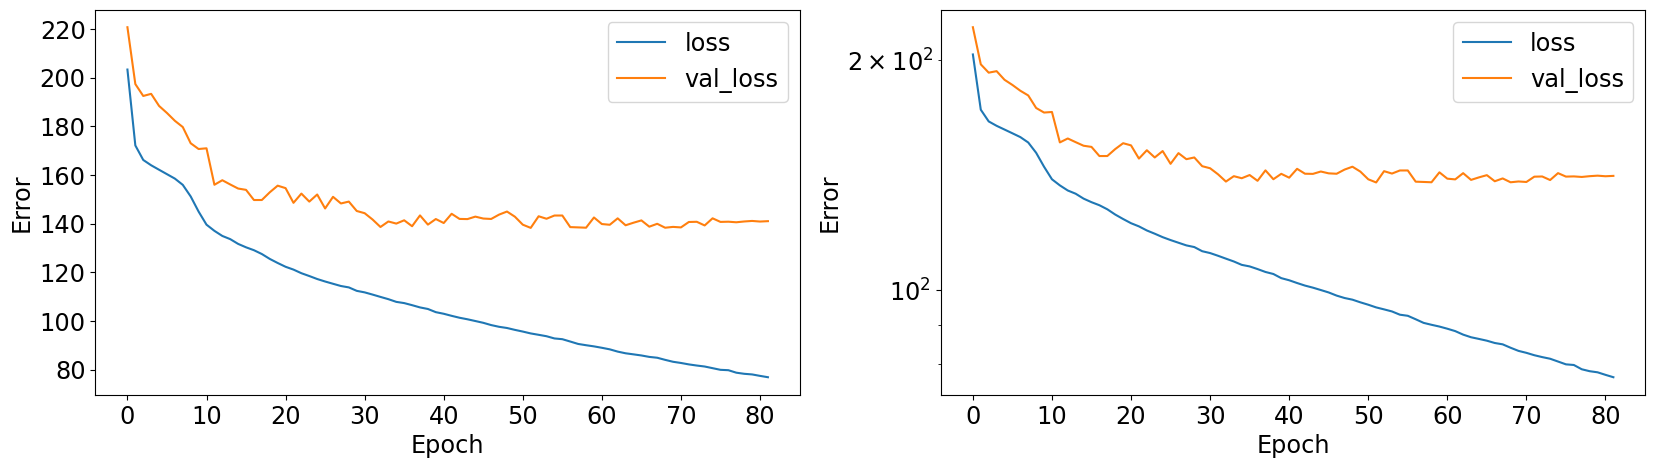

In [21]:
importlib.reload(project);

model_dual = project.trainModel(model_dual, train_data=train_batches, val_data=val_batches, nEpochs=300);

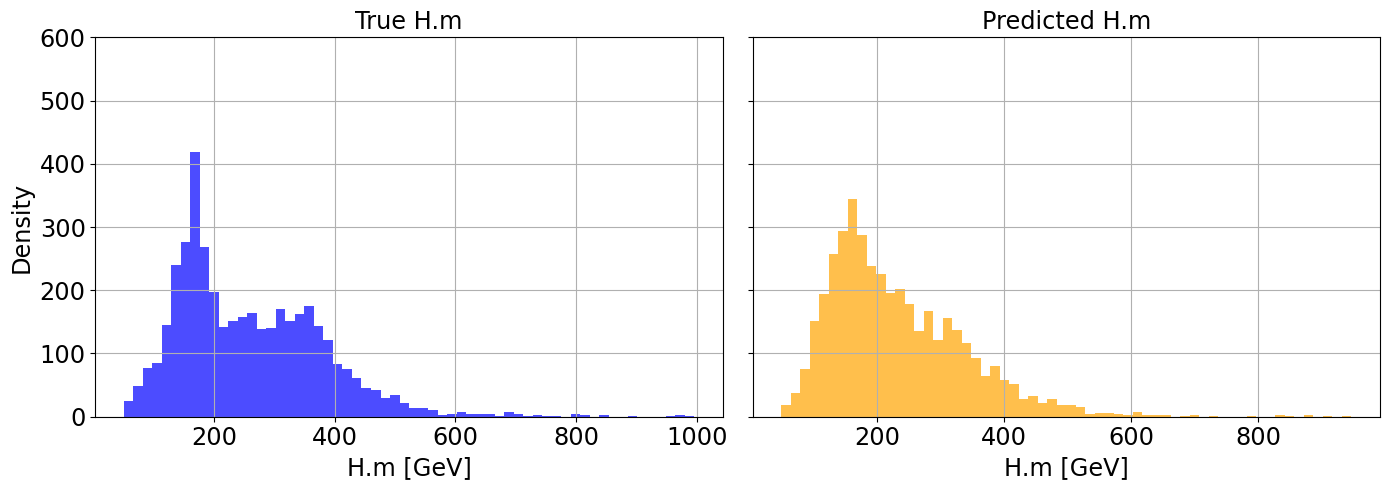

In [22]:
project.plot_H_mass(model_dual, val_batches)

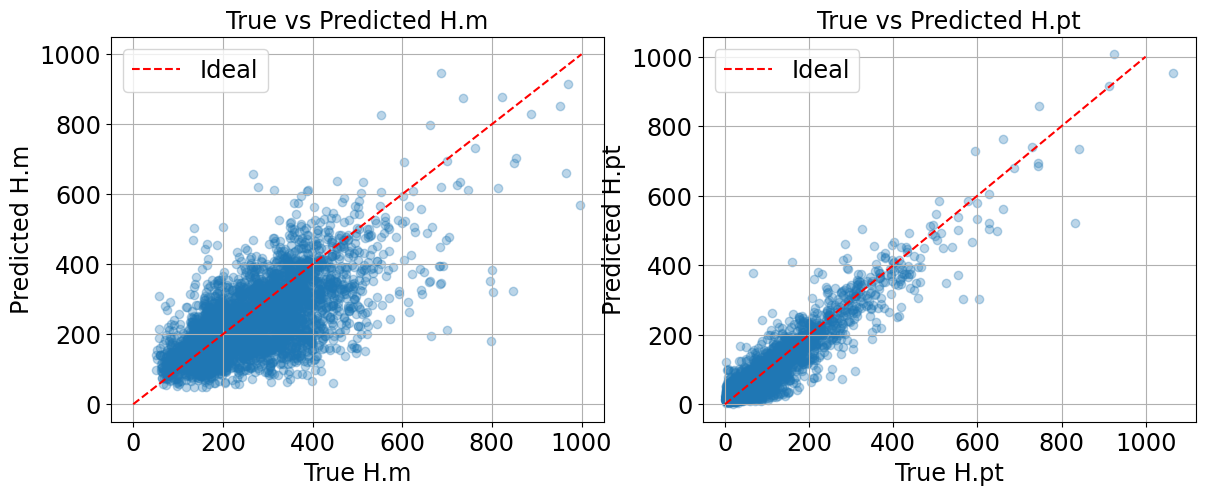

In [23]:
project.true_vs_predict_H_mass(model_dual, val_batches)

True Higgs mass:  491.7519  and predicted: 302.02356


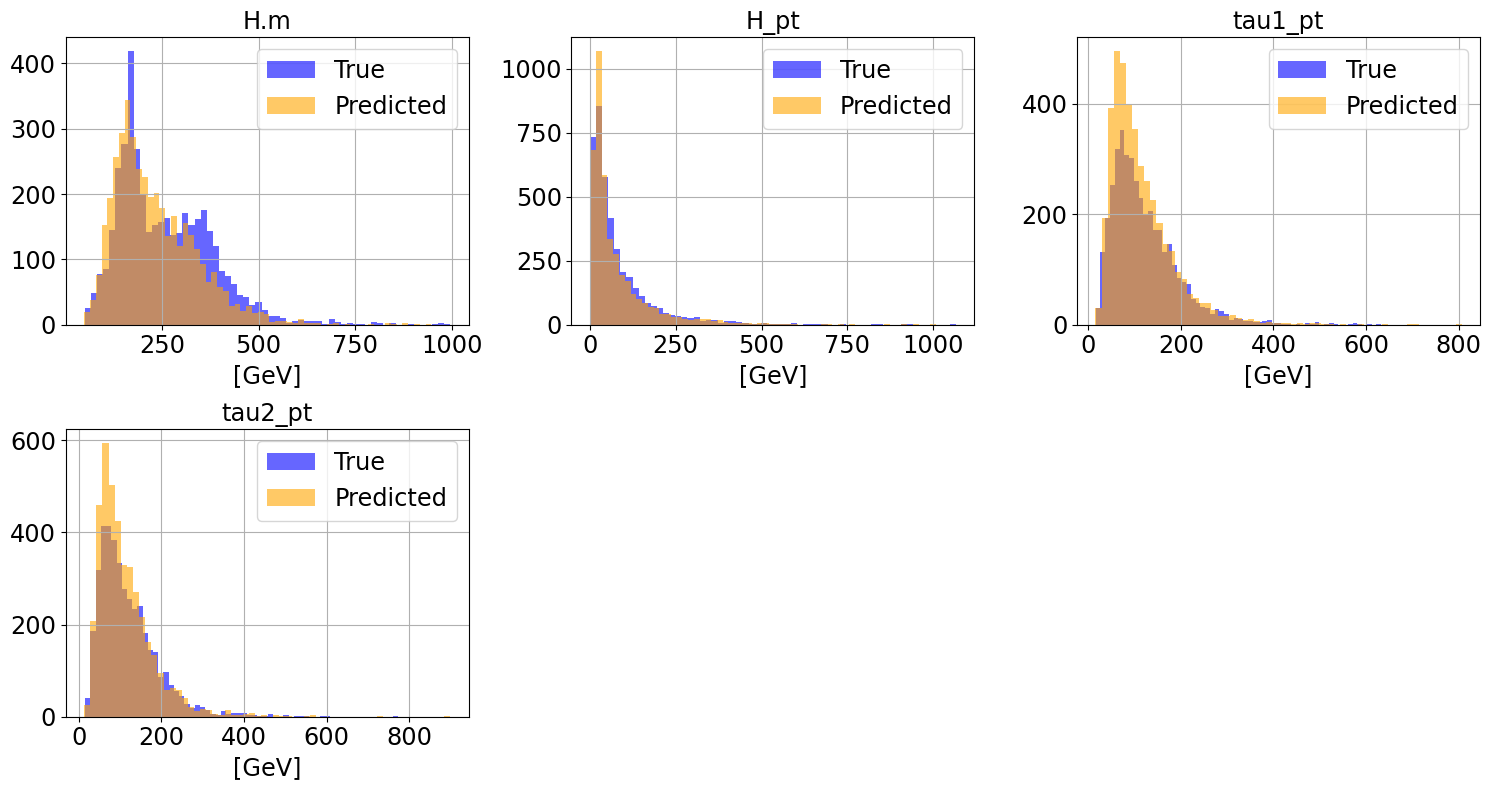

In [24]:
project.plot_all_labels(model_dual, val_batches, output_targets)

[H.m] sigma = 92.2770
[H_pt] sigma = 33.6910
[tau1_pt] sigma = 40.5743
[tau2_pt] sigma = 39.5876


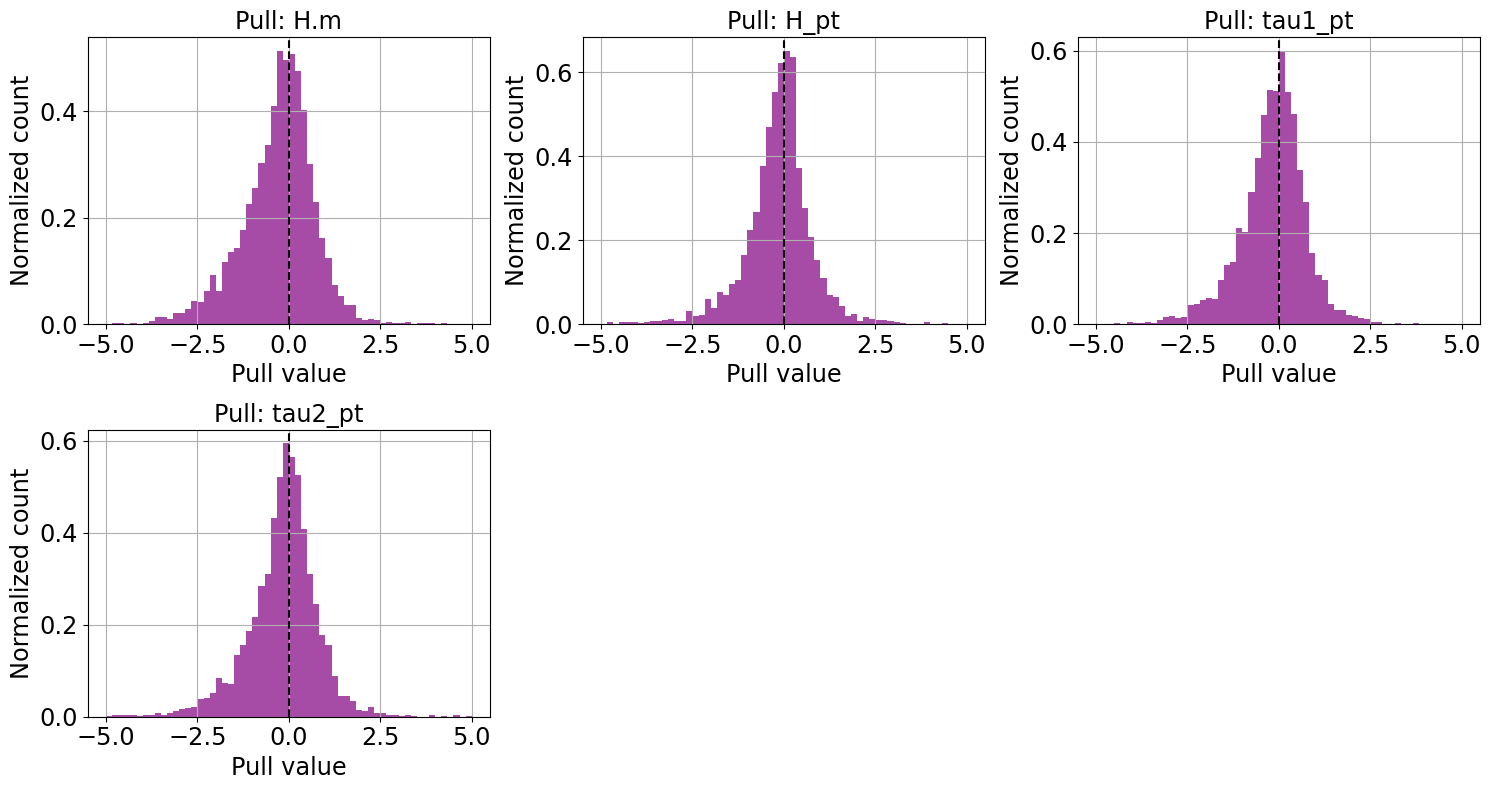

In [25]:
project.plot_all_pulls(model_dual, val_batches, output_targets)

Lepsze wyniki dał model_dual z architekturą dwugałęziową, choć nadal nie jest to oczekiwany rezulatat to jest lepszy niz w zwykłym FCC.